In [21]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [22]:
# Import dataset
print("Loading dataset...")
dataset = pd.read_csv("src/Building_Permits_Large.csv")
print("...Done.")

Loading dataset...


c:\Users\Baptiste Cournault\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3369: DtypeWarning: Columns (18,22,23,32,35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


...Done.


In [33]:
mask = dataset['Permit Type'] < 3

filtered_dataset = dataset.loc[mask, :]

In [34]:
filtered_dataset.shape

(15247, 53)

In [35]:
filtered_dataset = filtered_dataset.dropna(subset=['Estimated Cost'])

In [47]:
def romanToInt(s):
    roman = {'I':1,'V':5,'X':10,'L':50,'C':100,'D':500,'M':1000,'IV':4,'IX':9,'XL':40,'XC':90,'CD':400,'CM':900}
    i = 0
    num = 0
    while i < len(s):
        if i+1<len(s) and s[i:i+2] in roman:
            num+=roman[s[i:i+2]]
            i+=2
        else:
            #print(i)
            num+=roman[s[i]]
            i+=1
    return num

In [53]:
filtered_dataset['Proposed Construction Type'].value_counts().index

Index([5.0, 1.0, 3.0, 2.0, '5', 4.0, '1', '3', '2', '4', 'III'], dtype='object')

In [51]:
filtered_dataset['Proposed Construction Type'].apply(lambda x : romanToInt(x) if type(x)==str else x).fillna(0).astype(int)

KeyError: '5'

In [36]:
# Separate target variable Y from features X
print("Separating labels from features...")
features_list = [
    "Permit Type",
    "Unit",
    "Number of Proposed Stories", 
    "Plansets", 
    "Proposed Construction Type", 
    "Neighborhoods - Analysis Boundaries", 
    "Zipcode"
]

target_variable = "Estimated Cost"

X = filtered_dataset.loc[:,features_list]
Y = filtered_dataset.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())


Separating labels from features...
...Done.

Y : 
1       50000.0
2       50000.0
3     1000000.0
13    3100000.0
39     900000.0
Name: Estimated Cost, dtype: float64

X :
    Permit Type  Unit  Number of Proposed Stories  Plansets  \
1             2   NaN                         1.0       2.0   
2             2   NaN                         1.0       2.0   
3             2   NaN                         4.0       2.0   
13            1   NaN                         4.0       2.0   
39            2   NaN                         4.0       2.0   

   Proposed Construction Type Neighborhoods - Analysis Boundaries  Zipcode  
1                           5                        Inner Sunset  94122.0  
2                           5                        Inner Sunset  94122.0  
3                           5                    Presidio Heights  94118.0  
13                          3                     Treasure Island  94130.0  
39                          5                            Nob Hil

In [27]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['Permit Type', 'Unit', 'Number of Proposed Stories', 'Plansets', 'Zipcode']
Found categorical features  ['Proposed Construction Type', 'Neighborhoods - Analysis Boundaries']


In [28]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [29]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())
])

In [30]:
# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

In [31]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [32]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()

Performing preprocessings on train set...
        Permit Type  Unit  Number of Proposed Stories  Plansets  \
250927            2   NaN                         2.0       2.0   
597841            2   NaN                         4.0       2.0   
261118            2   3.0                         3.0       2.0   
505               2   NaN                         3.0       2.0   
263845            2   NaN                         3.0       2.0   

       Proposed Construction Type Neighborhoods - Analysis Boundaries  Zipcode  
250927                        5.0                           Excelsior  94112.0  
597841                        5.0                        Russian Hill  94109.0  
261118                        5.0                        Inner Sunset  94122.0  
505                             5               Bayview Hunters Point  94124.0  
263845                        5.0                           Glen Park  94131.0  


TypeError: Encoders require their input to be uniformly strings or numbers. Got ['float', 'str']

In [ ]:
np.isnan(Y_train).sum()

0

In [ ]:
# Train model
print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[ 1990679.48942761 11032689.61100871 16854316.9948333  ...
  3413814.2152266  -3857418.98534025  2158269.97234695]



In [ ]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[ 8.92877444e+06  1.42393463e+06  7.34885822e+06  5.10370820e+06
  1.72173123e+07  1.23527277e+07 -3.85741899e+06  7.69117398e+05
  5.21279569e+07  2.27448143e+07  1.11193972e+07 -2.56976008e+06
  6.23144608e+05 -5.11056911e+06 -3.85741899e+06  2.08689077e+07
  1.06535880e+08  1.55822079e+08  6.63883357e+06 -5.56952667e+06
 -1.82329944e+06  3.55732880e+07 -3.04044991e+06  2.15826997e+06
 -3.28113789e+06  1.82201002e+06 -6.90775051e+05  2.91823967e+06
  2.15826997e+06  2.15826997e+06 -1.74533806e+06  5.10370820e+06
  6.23144608e+05  6.10890841e+07 -6.65300469e+06  7.89437781e+06
  1.61066955e+07  7.25894709e+06  5.40838834e+07  8.92877444e+06
  7.87216411e+06 -7.13911717e+06  2.12640173e+07  2.15826997e+06
 -8.19200979e+06  1.20916925e+07  3.10927245e+07  2.95233379e+06
 -4.42529949e+05  3.58922938e+06  1.20916925e+07 -9.97105963e+05
  2.53200855e+07  4.07469911e+06  2.60045422e+06  2.10528197e+07
  1.63242714e+06 -3.85741899e+06  5.10370820e+06  6.23

In [ ]:
# Print R^2 scores
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.6062953912257653
R2 score on test set :  0.6265572002021339


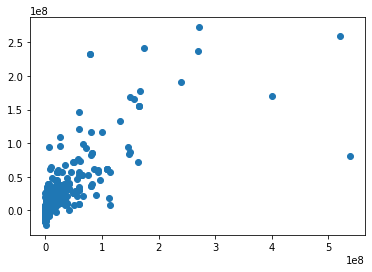

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(Y_train,Y_train_pred)